# Demo of Logits and Embeddings from a Language Model

In [83]:
# If the import fails, uncomment the following line:
#!pip install transformers
import torch
from torch import tensor
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
import matplotlib.pyplot as plt
# Avoid a warning message
import os; os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
model_name = 'openai-community/gpt2'
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left'
model = AutoModelForCausalLM.from_pretrained(model_name)

In [4]:
print(f"The tokenizer has {len(tokenizer.get_vocab())} strings in its vocabulary.")
print(f"The model has {model.num_parameters():,d} parameters.")

The tokenizer has 50257 strings in its vocabulary.
The model has 124,439,808 parameters.


## Tokenization

In [5]:
phrase = "Alice is my aunt, so my mother is her"

In [6]:
input_ids = tokenizer(phrase, return_tensors='pt')['input_ids']; input_ids

tensor([[14862,   318,   616, 25949,    11,   523,   616,  2802,   318,   607]])

## Embeddings

The model includes two modules that are very important: one at the very beginning, one at the very end.

In [7]:
token_embedding_module = model.transformer.wte
token_embedding_module

Embedding(50257, 768)

In [8]:
lm_head_module = model.lm_head
lm_head_module

Linear(in_features=768, out_features=50257, bias=False)

In [9]:
lm_head_module.weight.shape

torch.Size([50257, 768])

Notice the dimensionality is exactly symmetrical: `token_embedding` takes each token id and maps it to one of the 50k possible token embeddings (each one 768-dimensional); `lm_head` takes embeddings and maps them to logits corresponding to each of the 50k vocab entries.

It turns out that for this model, the token embeddings are identical on the input and output. This is called "tied weights" and is quite common now, to save parameters. This is easy to see and implement in PyTorch because `Linear` layers store their `W` matrices transposed internally already.

In [10]:
(token_embedding_module.weight.data == lm_head_module.weight.data).all()

tensor(True)

In [30]:
token_embedding_table = token_embedding_module.weight.data

## Example of mapping

The last token id is:

In [31]:
last_token_id = input_ids[0, -1]
print(last_token_id,
    "which corresponds to",
    repr(tokenizer.decode(last_token_id)))

tensor(607) which corresponds to ' her'


It has vector:

In [33]:
with torch.no_grad():
    last_token_embedding = token_embedding_module(last_token_id)
last_token_embedding.shape

torch.Size([768])

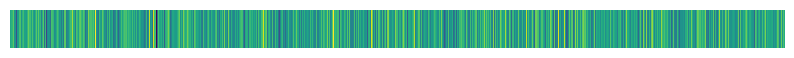

In [82]:
plt.figure(figsize=(10, .5))
plt.pcolormesh(last_token_embedding[None, :])
plt.axis('off');

(The specific numbers in there are illegibile, so we hide them.)

Passing a vector through a linear layer is equivalent to computing the dot product with all of its rows (since the bias terms are all set to 0), so we're going to see the dot product of `vec` with all of the token embeddings.

In [35]:
with torch.no_grad():
    last_token_dot_products = lm_head_module(last_token_embedding)
last_token_dot_products.shape

torch.Size([50257])

In [84]:
print([tokenizer.decode(x) for x in last_token_dot_products.topk(k=10).indices])

[' her', ' hers', ' herself', 'Her', ' she', 'She', 'she', ' HER', ' Her', ' She']


> Astute observers will notice that the token space is wasted by some minor variants of the same token. Current research has improved on this slightly by allowing these related tokens to share information, but it doesn't make a big difference.


If we do this for all the input tokens at the same time, we get the most similar tokens for each input token. That will almost always be the token itself, but note that the token embeddings are not explicitly normalized so the dot product with a different token's embedding may turn out to be the largest one just because it's a different magnitude.

In [19]:
import pandas as pd
logits = lm_head_module(token_embedding_module(input_ids))
for y in logits.topk(k=10, axis=2).indices[0]:
    print([tokenizer.decode(x).replace(' ', '_') for x in y])

['_Alice', 'Alice', '_Wonderland', '_Ellen', '田', '_Eleanor', '_Sakuya', '_Louise', '_Ellie', '_Alic']
['_is', '_has', '_was', '_does', '_are', '_will', "'s", '_isn', '_can', '_may']
['_my', 'My', '_myself', 'my', '_MY', '_My', '_me', '_our', '_mine', '_I']
['_aunt', '_Aunt', '_niece', '_grandmother', '_uncle', '_grandma', 'uncle', '_granddaughter', '_nephew', '_grandparents']
[',', '.', '-', "'s", ':', '/', ';', ')', '"', '?']
['_so', 'so', '_So', 'So', '_SO', '_thus', '_mathemat', '_such', '_too', '_rul']
['_my', 'My', '_myself', 'my', '_MY', '_My', '_me', '_our', '_mine', '_I']
['_mother', 'Mother', 'mother', '_mothers', '_mom', '_father', '_grandmother', '_moms', '_Mother', '_maternal']
['_is', '_has', '_was', '_does', '_are', '_will', "'s", '_isn', '_can', '_may']
['_her', '_hers', '_herself', 'Her', '_she', 'She', 'she', '_HER', '_Her', '_She']


## Vector Analogies

In [41]:
# get the vectors for the tokens "he", "she", and "his"
@torch.no_grad()
def get_vector(token):
    token_id = tokenizer.encode(token)
    return token_embedding_table[token_id[0]]
    
he = get_vector("he")
she = get_vector("she")
his = get_vector("his")

he.shape, she.shape, his.shape

(torch.Size([768]), torch.Size([768]), torch.Size([768]))

In [40]:
direction = she - he
query_vector = his + direction
query_vector.shape

torch.Size([768])

In [43]:
# find the token with the highest dot product with the query vector
dot_products = token_embedding_table @ query_vector
closest_token = dot_products.argmax()
tokenizer.decode([closest_token])

' her'

In [44]:
small = get_vector("small")
big = get_vector("big")
biggest = get_vector("biggest")

tokenizer.decode([
    (token_embedding_module.weight.data @ (small + (biggest - big))).argmax(),
])

' smallest'

# What the model does
(The "[Logit Lens](https://www.lesswrong.com/posts/AcKRB8wDpdaN6v6ru/interpreting-gpt-the-logit-lens)")

When the model processes its input, it first looks up the embedding for each input token to produce its first "hidden states". Then it incrementally applies each layer of the model (consisting, in this case, of a self-attention "mixing" layer followed by a (one-token-at-a-time) feed-forward "mapping" layer), obtaining incrementally more refined hidden states that approach the context vector for the next token.

In [85]:
with torch.no_grad():
    model_output = model(input_ids, output_hidden_states=True, output_attentions=True)
hidden_states = model_output.hidden_states

In [86]:
len(hidden_states) # this is model.config.n_layer + 1, to include the input embeddings.

13

In [103]:
layer = 0

if layer < 0: layer += len(hidden_states)
logits = lm_head_module(hidden_states[layer])
for seq_idx, y in enumerate(logits.topk(k=10).indices[0]):
    token_in_input = tokenizer.decode(input_ids[0, seq_idx])
    print(f"Most similar to hidden state before layer {layer} at token {seq_idx} ({token_in_input}):")
    print([tokenizer.decode(x) for x in y])
    print()

Most similar to hidden state before layer 0 at token 0 ( Alice):
[' Alice', 'Alice', '���', 'ּ', 'ignty', 'wcsstore', '▬', '��', '田', 'bil']

Most similar to hidden state before layer 0 at token 1 ( is):
[' is', ' has', ' was', ' will', "'s", ' can', ' does', ' isn', ' may', ' are']

Most similar to hidden state before layer 0 at token 2 ( my):
[' my', 'my', ' myself', 'My', ' My', ' MY', ' me', ' our', ' mine', ' mathemat']

Most similar to hidden state before layer 0 at token 3 ( aunt):
[' aunt', ' niece', ' Aunt', ' grandmother', ' uncle', 'uncle', ' cousin', ' grandma', 'unts', ' grandparents']

Most similar to hidden state before layer 0 at token 4 (,):
[',', '.', '-', ':', "'s", '/', ';', '"', ')', ' and']

Most similar to hidden state before layer 0 at token 5 ( so):
[' so', 'so', 'So', ' So', ' mathemat', ' thus', 'theless', ' arrang', ' destro', ' SO']

Most similar to hidden state before layer 0 at token 6 ( my):
[' my', 'my', ' myself', 'My', ' MY', ' My', ' me', ' mathemat'

> Astute readers will notice that the most similar tokens to the *input* embeddings (the first hidden state) aren't exactly the same as the most similar tokens to the *token* embeddings. That's because the Transformer model constructs its input embeddings by adding the *token* embeddings and *position* embeddings. The position embeddings enable the model to distinguish between different positions in the input sequence.

Note: the predictions after the first token aren't great because the LM has very little context to work with. As it gets more context, the predictions get better.

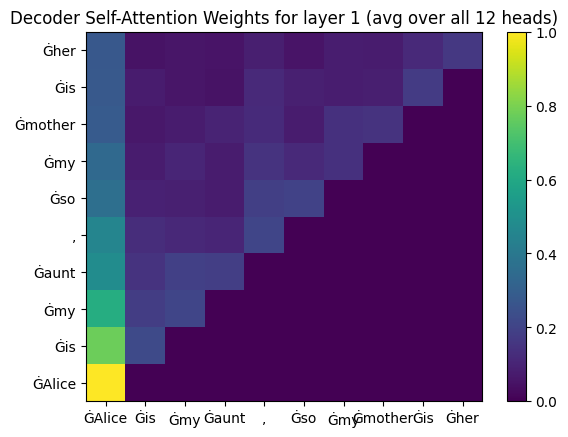

In [67]:
layer = 1
plt.pcolormesh(model_output.attentions[layer][0].mean(dim=0).cpu().numpy())
plt.title(f"Decoder Self-Attention Weights for layer {layer} (avg over all {model.config.num_attention_heads} heads)")
plt.xticks(torch.arange(len(input_ids[0]))+.5, tokenizer.convert_ids_to_tokens(input_ids[0]))
plt.yticks(torch.arange(len(input_ids[0]))+.5, tokenizer.convert_ids_to_tokens(input_ids[0]))
plt.colorbar();